# Indiviudal Research Project:

# Libraries:

In [ ]:
# Libraries
import matplotlib.pyplot as plt
from PIL import Image

import zipfile
from zipfile import ZipFile
from pathlib import Path

import pandas as pd
import io
import os
import time
import random

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models

import numpy as np
import torch
from torch.utils.tensorboard.writer import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.nn import init
from torch.autograd import Variable
from torch.utils.data import DataLoader

import re
run_id = 'AllTogether'
dir = os.path.join('/content/drive/My Drive/Data/logs', run_id)
writer = SummaryWriter(log_dir = dir ) # Initializes TensorBoard
# Identify run
%load_ext tensorboard
%tensorboard --logdir '{dir}'

# Custom Functions:

In [ ]:
# Together atoi and natural_keys allow 'human sorting'
# sorted function resulted in the points and images not aligning cause the frames were sorted by computer logic
def atoi(text):
    return int(text) if text.isdigit() else text
    
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


# Custom Dataset:

In [ ]:
# Custom Dataset
# img_locs = 'ImagesAnnotated'
# pt_locs = 'Annotated Frames'

class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_locs, pt_locs, transform = None):
        '''

        Parameters
        ----------
        img_locs : string
            Name of the folder containing the images.
        pt_locs : string
            Name of the folder containing the points.
        transform : function, optional
            Put transformation functions you want applied to the data set here

        -------
        

        '''
        self.img_locs = img_locs
        self.pt_locs = pt_locs
        # Get list of all images in folder given as input
        self.imglist = list(sorted(os.listdir(os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Data', img_locs))))
        self.imglist.sort(key = natural_keys)
        # Get list of all points, want points as a tuple integer, not string tho
        # To do this need list of all files we want points from
        ptfileslist = list(sorted(os.listdir(os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Data', pt_locs))))
        pts = [] # Initialize list where we'll store the coord points
        fractpts = [] # Initialize list where we'll store the coord points as fractions of the image
        for i in range(0, len(ptfileslist)): # runs through all .txt files we want
            txtfile = open(os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Data', pt_locs, ptfileslist[i]), 'r') # Open file
            for line in txtfile: # runs through .txt file line by line
                hcoord = line[18:21] # Pulls out height coord
                wcoord = line[23:26] # Pulls out width coord
                pts.append((int(hcoord), int(wcoord))) # adds coords to list as ints
                fractpts.append(((int(hcoord)/480), (int(wcoord)/640))) # gets points as a fraction of the image height and width
            txtfile.close() # closes txtfile
        self.points = np.array(pts)  # saves coord list as a callable np.array   
        # want points to be fractions of image length and height
        self.fract_points = np.array(fractpts)
        self.transform = transform
        
    # Want to be able to call image and points, i.e. need to return a sample 
    def __getitem__(self, idx):
        """
        

        Parameters
        ----------
        idx : the sample you are calling
        

        Returns
        -------
        Sample: a dictionary containing an image and coords of a tip 

        """
        # Get idxth image
        image_name = self.imglist[idx]
        image = np.array(Image.open(os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Data', self.img_locs, image_name)))
        image = np.moveaxis(image, 2, 0) # moves np array so structure is (channels, h, w) like network will require
        # Copy of image (not linked)
        cimage = list(image)
        cimage = np.array(image)

        # Get idxth point
        point = list(self.points[idx])
        point = np.array(point)
        # Copy of point (not linked)
        cpoint = list(point)

        # Get idxth point as fraction of the image height/width
        fractpoint = self.fract_points[idx]
 
        
        # Create sample
        sample = {'image': image, 
                  'point': point,
                  'fractional point': fractpoint,
                  'og point': cpoint }
        
        # Transform Sample
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        
    def __len__(self):
        # Gets number of samples inside the dataset 
        return len(self.imglist)


# Transform Function for Dataset

In [ ]:
# Transforms 
class Normalise(object):
    """
    Normalise the intensities in an image
    """
    def __init__(self, min_ = 0, max_ = 1):
        self.min = min_
        self.max = max_
        
    def __call__(self, sample):
        image, point, fractpoint, og = sample['image'], sample['point'], sample['fractional point'], sample['og point']
        # Normalize between self.min and self.max
        image = (self.max - self.min) * \
            (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-10) + self.min
        # Note normalize comes before ToTensor as assumes image still in np array
        # ToTensor should always go last in transform composite 
        
        # Resave to sample
        print('HERE')
        sample = {'image': image,
                  'point': point,
                  'fractional point': fractpoint,
                  'og point': og }
        
        return sample


class Jitter(object):
  """
  Converts np array to PIL image applies Jitter and converts back to numpy
  """
  def __call__(self, sample):
    image, point, fractpoint, og = sample['image'], sample['point'], sample['fractional point'], sample['og point']
    image2 = np.moveaxis(image, 0, 2) # Fixes axis to that of typical np array (needed for PIL type)
    PILimage = Image.fromarray(image2) # Makes PIL type (necessary for Jitter)
    jitterimg = transforms.ColorJitter(.5,.5,.5,.5)(PILimage) # Transforms
    npimg = np.array(jitterimg) # Turns jittered img back to np
    npimg = np.moveaxis(npimg, 2, 0) # Changes axis back to what program will require later

    # Resave to sample
    sample = {'image': npimg,
              'point': point,
              'fractional point': fractpoint,
              'og point': og }
        
    return sample


class Flip(object):
  """
  Flips img (left/right or up/down), and adjusts point
  """
  def __call__(self, sample):
    image, point, fractpoint, og = sample['image'], sample['point'], sample['fractional point'], sample['og point']
    randomint = random.randint(0,1)
    if randomint > .5: # randomly decides what kind of flip we use
      flipimg = np.flip(image, axis = 1) # Vertial Flip
      oglist = list(og)
      if np.all(point == oglist):
        point[0] = 480 - point[0] # Fixes point to new location
        fractpoint[0] = point[0]/480 # Fixes fractional point to new location
    else:
      flipimg = image 
    
    # Resave to sample
    sample = {'image': flipimg,
              'point': point,
              'fractional point': fractpoint,
              'og point': og }

    return sample


class ToTensor(object):
    """
    Converts np arrays in Sample to Tensors
    """
    def __call__(self, sample):
        image, point, fractpoint, og = sample['image'], sample['point'], sample['fractional point'], sample['og point'] # saves img and pt are vars
        # Convert to torch
        torchimage = torch.from_numpy(image)
        torchpoint = torch.from_numpy(point)
        torchfractpoint = torch.from_numpy(fractpoint)
        # Resave to sample
        sample = {'image': torchimage.float(),
                  'point': torchpoint.float(),
                  'fractional point': torchfractpoint.float(),
                  'og point': og }
        
        return sample

# Neural Network

In [ ]:
# Define the neural network
model = torchvision.models.alexnet(pretrained=False, progress=True, num_classes = 2, )
# Literally just load the alexnet model
# We're trying le shit out
modelinfo = model.eval()

In [ ]:
print(modelinfo)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
print(model.parameters())

<generator object Module.parameters at 0x7fbca78e9f50>


# Creating Our Dataset

In [ ]:
# Create dataset, use ToTensor() to put into Tensor type
dataset = Dataset('Images Annotated', 'Annotated Frames', transform = transforms.Compose([Flip(), Jitter(), Normalise(), ToTensor()]) ) # add augmentations to dataset
# Split dataset into training and testing 80-20
train_ds, test_ds = torch.utils.data.random_split(dataset, (467, 116))
# Use Pytorch dataloader 
train = torch.utils.data.DataLoader(train_ds, batch_size = 10, shuffle = True)
test = torch.utils.data.DataLoader(test_ds, batch_size= 1 , shuffle = False)


FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(test)

Test DataLoader

Image Train:  torch.Size([10, 3, 480, 640])
Point Train:  torch.Size([10, 2])
(10, 3, 480, 640)
(10, 480, 640, 3)


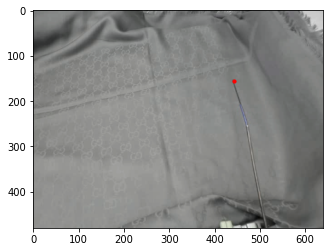

Image Train:  torch.Size([10, 3, 480, 640])
Point Train:  torch.Size([10, 2])
(10, 3, 480, 640)
(10, 480, 640, 3)


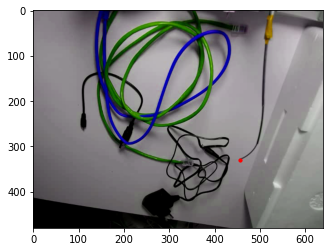

Image Train:  torch.Size([10, 3, 480, 640])
Point Train:  torch.Size([10, 2])
(10, 3, 480, 640)
(10, 480, 640, 3)


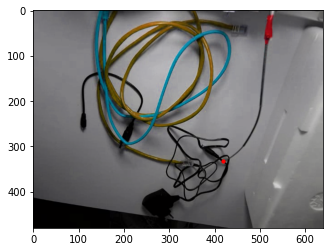

Image Train:  torch.Size([10, 3, 480, 640])
Point Train:  torch.Size([10, 2])
(10, 3, 480, 640)
(10, 480, 640, 3)


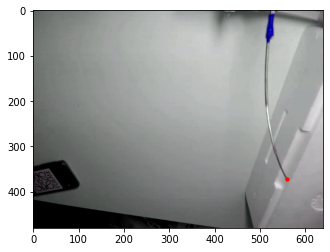

Image Train:  torch.Size([10, 3, 480, 640])
Point Train:  torch.Size([10, 2])
(10, 3, 480, 640)
(10, 480, 640, 3)


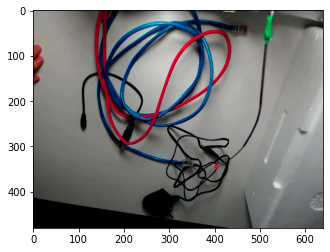

Image Train:  torch.Size([10, 3, 480, 640])
Point Train:  torch.Size([10, 2])
(10, 3, 480, 640)
(10, 480, 640, 3)


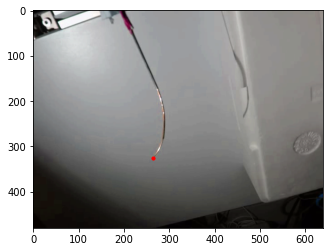

Image Train:  torch.Size([10, 3, 480, 640])
Point Train:  torch.Size([10, 2])
(10, 3, 480, 640)
(10, 480, 640, 3)


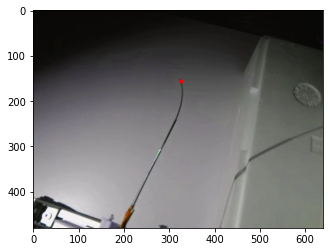

583

In [ ]:
# Test DataLoader in seperate cell so we don't have to always run it
for i, batch in enumerate(train):
  image_train, point_train = batch['image'], batch['point']
  print('Image Train: ', image_train.shape)
  print('Point Train: ', point_train.shape)
  # Plot the images
  image_train = np.array(image_train)
  print(image_train.shape)
  image_train = np.moveaxis(image_train, 1, 3)
  print(image_train.shape)
  plt.imshow(image_train[0,:,:,:])
  plt.scatter(point_train[0,1], point_train[0,0], c = 'r', s = 10) # plots robot tip point
  plt.show()


  if i > 5:
    break

len(dataset)


# Training the Network

In [ ]:
# Training Parameters/Functions
epochs = 50 # number of iterations
learning_rate = .0001 # learning rate .0001

loss_function = torch.nn.MSELoss() # Mean Square Error built-in function 
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

loss_list = []
valloss_list = []
count = 0
counter = 0
# Training
# runs through number of iterations
for iterate in range(1, epochs):
    # runs through all samples in dataloader train
    for i, sample_ in enumerate(train):
        
        # Clear Gradients
        optim.zero_grad()
        counter = counter + 1
        
        # Declare image input (must be in 2nd loop as changes as we go through train dataloader)
        img_input = Variable(sample_['image'])
        # Declare known point of these images (ground truth)
        pt_gt = Variable(sample_['point'])
        fractpt_gt = Variable(sample_['fractional point'])
        
        # Forward Pass
        prediction = model(img_input)

        # Turns prediction to coord point for loss
        x = torch.reshape(prediction[:,0]*480, (-1,1))
        y = torch.reshape(prediction[:,1]*640, (-1,1))
        # Reshapes predicition into correct format
        wholepred = torch.cat((x,y), dim = 1)

        # Calculate Loss
        current_loss = loss_function(wholepred, pt_gt)
        # Add Training Loss to TensorBoard
        writer.add_scalars('Loss/Train', {'lr.0001': current_loss}, counter)
        # Want counter not epoch, as loss changes for every i running through epoch as well
        # Ask Christos and Claudio if should update loss only once for each epoch
        
        # Store Loss
        loss_list.append(current_loss)
        
        # Backward Pass
        current_loss.backward()
        
        # Update weights
        optim.step()
        
        print('Sample ' + str(i))

        
        if i == 2:
            count = count + 1
            fig = plt.figure()
            plt.imshow(img_input[0,0,:,:])
            plt.scatter(pt_gt[0,1], pt_gt[0,0], c = 'r')
            plt.scatter((prediction[0,1].detach().numpy())*640, (prediction[0,0].detach().numpy())*480, c = 'b')
            plt.title('Iteration ' + str(count))
            writer.add_figure("Training/Image.1", fig, global_step=count)
            plt.show()

            # Validation 
            for i, valid in enumerate(test):
              with torch.no_grad():
                figval = plt.figure()
                validimg = valid['image']
                validimg = Variable(validimg)
                validpts = Variable(valid['point'])
                validfracpts = Variable(valid['fractional point'])
                valpred = model(validimg)
                x2 = torch.reshape(valpred[:,0]*480, (-1,1))
                y2 = torch.reshape(valpred[:,1]*640, (-1,1))
                wholepred2 = torch.cat((x2,y2), dim = 1)
                valloss = loss_function(wholepred2, validpts)
                writer.add_scalars('Loss/Valid', { 'lr.0001': valloss}, count)
                valloss_list.append(valloss)
                plt.imshow(validimg[0,0,:,:])
                plt.scatter(validpts[0,1], validpts[0,0], c = 'r')
                plt.scatter((valpred[0,1].detach().numpy())*640, (valpred[0,0].detach().numpy())*480, c = 'b')
                writer.add_figure("Validation/Image.1", figval, global_step = count)
                plt.show()
                break



        
    # Prints what epoch we're on     
    print('Iteration ' + str(iterate) + ' Completed!')
    

# flush() method makes sure that all pending events have been written to disk 
writer.flush()
writer.close() # For now we end the writer here but later will want this after we've finished all Writer things (after Testing)


Sample 0
Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Sample 6
Sample 7
Sample 8
Sample 9
Sample 10
Sample 11
Sample 12
Sample 13
Sample 14
Sample 15
Sample 16
Sample 17
Sample 18
Sample 19
Sample 20
Sample 21
Sample 22
Sample 23
Sample 24
Sample 25
Sample 26
Sample 27
Sample 28
Sample 29
Sample 30
Sample 31
Sample 32
Sample 33
Sample 34
Sample 35
Sample 36
Sample 37
Sample 38
Sample 39
Sample 40
Sample 41
Sample 42
Sample 43
Sample 44
Sample 45
Sample 46
Iteration 1 Completed!
Sample 0
Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Sample 6
Sample 7
Sample 8
Sample 9
Sample 10
Sample 11
Sample 12
Sample 13
Sample 14
Sample 15
Sample 16
Sample 17
Sample 18
Sample 19
Sample 20
Sample 21
Sample 22
Sample 23
Sample 24
Sample 25
Sample 26
Sample 27
Sample 28
Sample 29
Sample 30
Sample 31
Sample 32
Sample 33
Sample 34
Sample 35
Sample 36
Sample 37
Sample 38
Sample 39
Sample 40
Sample 41
Sample 42
Sample 43
Sample 44
Sample 45
Sample 46
Iteration 2 Completed!
Sample 0
Sample 1
Sample 2
Sample 

# Testing the Network

In [ ]:
for i, sample_test in enumerate(test):
    
    # Image Data
    image_test, point_test, fract_test = sample_test['image'], sample_test['point'], sample_test['fractional point']
    image_test_input = Variable(image_test)
    
    # Prediction
    with torch.no_grad(): # No grad involved with test
      prediction_test = model(image_test_input)
      figtest = plt.figure()
      plt.imshow(image_test_input[0, 0, :, :])
      plt.scatter(point_test[0,1], point_test[0,0], c = 'r')
      plt.scatter((prediction_test[0,1].detach().numpy())*640, (prediction_test[0,0].detach().numpy())*480, c = 'b')
      plt.title('Testing Image ' + str(i))
      writer.add_figure("Test/Image", figtest, global_step = i)
      plt.show()

In [ ]:
lossallaug = loss_list[:]
vallossallaug = valloss_list[:]